# Import packages + functions

In [2]:
import os
import sys
import math
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from subprocess import call
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

device: cpu


# Load NSD webdatasets for a given subject

The '/fsx' directory refers to a directory housed on the Stability HPC. You will need to download NSD data from [our huggingface dataset](https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main) and change the folders below to your own folder path. If you have demonstrated serious involvement with the project and need access to the Stability HPC contact Paul Scotti on Discord.

In [3]:
# Preprocessing for images
transform = transforms.Compose([
    transforms.Resize(224),
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess(sample):
    voxel, image = sample
    return voxel, transform(image)

In [4]:
subject = '01'

num_devices = torch.cuda.device_count()
if num_devices==0: # not using gpu, assuming you want to use the limited dataset
    num_devices = 1
    num_workers = 1
    batch_size = 300
    num_samples = 9000
else: # using cuda, assuming you want to use the full dataset
    num_workers = num_devices
    batch_size = 300
    num_samples = 9000 # see metadata.json
print("num_devices",num_devices)
print("num_workers",num_workers)
print("batch_size",batch_size)
global_batch_size = batch_size * num_devices
print("global_batch_size",global_batch_size)
num_batches = math.floor(num_samples / global_batch_size)
num_worker_batches = math.floor(num_batches / num_workers)
print("num_worker_batches",num_worker_batches)
# train_url = f'/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/train/train_subj{subject}'
train_url = f'/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj{subject}'
train_url = train_url+"_{0..49}.tar"

# train_data = wds.DataPipeline([wds.ResampledShards(train_url),
#                     wds.tarfile_to_samples(),
#                     #wds.shuffle(500,initial=500),
#                     wds.decode("torch"),
#                     wds.rename(images="jpg;png", voxels="nsdgeneral.npy", trial="trial.npy"),
#                     wds.to_tuple("voxels", 'images'),
#                     wds.map(preprocess),
#                     wds.batched(batch_size, partial=False),
#                 ]).with_epoch(num_worker_batches)

train_data = wds.WebDataset(train_url, resampled=False, nodesplitter=wds.split_by_node)\
    .decode("torch")\
    .rename(images="jpg;png", voxels="nsdgeneral.npy", trial="trial.npy")\
    .to_tuple("voxels", 'images')\
    .map(preprocess)\
    .batched(batch_size, partial=False)\
    .with_epoch(num_worker_batches)
train_dl = torch.utils.data.DataLoader(train_data, batch_size=None, num_workers=num_workers, shuffle=False)

# Validation #
# num_samples = 492
num_samples = 300
num_batches = math.ceil(num_samples / global_batch_size)
num_worker_batches = math.floor(num_batches / num_workers)
print("validation: num_worker_batches",num_worker_batches)

# val_url = f'/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/val/val_subj{subject}_0.tar'
val_url = f'/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj{subject}_0.tar'

# val_data = wds.DataPipeline([#wds.SimpleShardList(val_url),
#                     wds.tarfile_to_samples(val_url),
#                     wds.decode("torch"),
#                     wds.rename(images="jpg;png", voxels="nsdgeneral.npy", trial="trial.npy"),
#                     wds.to_tuple("voxels", 'images'),
#                     wds.map(preprocess),
#                     wds.batched(batch_size, partial=False),
#                 ]).with_epoch(num_worker_batches)

val_data = wds.WebDataset(val_url, resampled=False, nodesplitter=wds.split_by_node)\
    .decode("torch")\
    .rename(images="jpg;png", voxels="nsdgeneral.npy", trial="trial.npy")\
    .to_tuple("voxels", 'images')\
    .map(preprocess)\
    .batched(batch_size, partial=False)\
    .with_epoch(num_worker_batches)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, num_workers=num_workers, shuffle=False)

num_devices 1
num_workers 1
batch_size 300
global_batch_size 300
num_worker_batches 30
validation: num_worker_batches 1


In [5]:
# check that your training data loaders are working
for train_i, (voxel, img_input) in enumerate(train_dl):
    print("idx",train_i)
    print("voxel.shape",voxel.shape,voxel[0,20:24])
    print("img_input.shape",img_input.shape,img_input[0,0,0,100:104])
    if train_i>2:
        break

idx 0
voxel.shape torch.Size([300, 15724]) tensor([-0.5537, -0.6250, -0.5928, -1.1855], dtype=torch.float16)
img_input.shape torch.Size([300, 3, 224, 224]) tensor([-0.2727,  1.1480,  1.8288,  1.8201])
idx 1
voxel.shape torch.Size([300, 15724]) tensor([-0.1572,  1.3652,  0.8164, -0.7310], dtype=torch.float16)
img_input.shape torch.Size([300, 3, 224, 224]) tensor([0.8172, 0.8172, 0.7974, 0.7688])
idx 2
voxel.shape torch.Size([300, 15724]) tensor([-0.2185, -0.0928, -0.9380, -0.6802], dtype=torch.float16)
img_input.shape torch.Size([300, 3, 224, 224]) tensor([-0.3197, -0.3027, -0.2432, -0.2646])
idx 3
voxel.shape torch.Size([300, 15724]) tensor([-1.8115, -2.0488, -0.2144, -1.5723], dtype=torch.float16)
img_input.shape torch.Size([300, 3, 224, 224]) tensor([-1.5448, -1.5289, -1.4297, -1.2294])


In [6]:
# check that validation data loader is working
for val_i, (voxel, img_input) in enumerate(tqdm(val_dl)):
    print("idx",val_i)
    print("voxel.shape",voxel.shape,voxel[0,20:24])
    print("img_input.shape",img_input.shape,img_input[0,0,0,100:104])
    if train_i>2:
        break

0it [00:02, ?it/s]

idx 0
voxel.shape torch.Size([300, 15724]) tensor([ 1.0420,  1.2803, -0.4688,  1.0654], dtype=torch.float16)
img_input.shape torch.Size([300, 3, 224, 224]) tensor([-0.2052, -0.1773, -0.1589, -0.2151])


In [7]:
# check validation batches are working correctly
# nothing prints out if correct
for train_i, (voxel, img_input) in enumerate(tqdm(val_dl)):
    if voxel.shape[0]!=batch_size:
        print("idx",train_i)
        print("voxel.shape",voxel.shape,voxel[0,20:24])
        print("img_input.shape",img_input.shape,img_input[0,0,0,100:104])
        break

1it [00:02,  2.76s/it]


In [8]:
# check that batches are deterministic
for val_i, (voxel, img_input) in enumerate(tqdm(train_dl)):
    if val_i==0:
        voxel_1 = voxel
        break
        
for val_i, (voxel, img_input) in enumerate(tqdm(train_dl)):
    if val_i==0:
        voxel_2 = voxel
        break
        
print(torch.sum(voxel_1-voxel_2))

0it [00:05, ?it/s]
0it [00:04, ?it/s]

tensor(0., dtype=torch.float16)


### Load Algonauts images from test split

In [9]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):
    
    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

data_dir = '../algonauts_2023_challenge_data'
parent_submission_dir = 'algonauts_2023_challenge_submission'
subj = 1 

args = argObj(data_dir, parent_submission_dir, subj)

In [10]:
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create list will all test image file names, sorted
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
idxs_test = np.arange(len(test_img_list))
print('Test stimulus images: ' + format(len(idxs_test)))

Test stimulus images: 159


In [11]:
transform_test = transforms.Compose([
    transforms.Resize(224),
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = PIL.Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

In [21]:
batch_size = 300 #@param
# Get the paths of all image files
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
test_imgs_dataloader = torch.utils.data.DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform_test), 
    batch_size=batch_size
)

# Train model (input = image; output = predicted fMRI)

### load pretrained alexnet

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet') # run in commandline if not loading
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in /home/dw26/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Extract and downsample chosen alexnet features

In [15]:
# load model
model_layer = "features.2"  # choose layer
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])

In [16]:
print(feature_extractor)

AlexNet(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)



def forward(self, x : torch.Tensor):
    features_0 = getattr(self.features, "0")(x);  x = None
    features_1 = getattr(self.features, "1")(features_0);  features_0 = None
    features_2 = getattr(self.features, "2")(features_1);  features_1 = None
    return {'features.2': features_2}
    


In [17]:
# Incremental PCA computes features
from sklearn.decomposition import IncrementalPCA

def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=batch_size)
    # Fit PCA to batch
    for _, (voxel, img) in enumerate(tqdm(dataloader)):
        # Extract features
        ft = feature_extractor(img.to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

In [18]:
pca = fit_pca(feature_extractor, train_dl)

30it [05:40, 11.34s/it]


In [19]:
# gets principal components of features for each images using derived PCA
# while going through dataset, also prepare training/validation fMRI matrix from dataloader for regression
def extract_features(feature_extractor, dataloader, pca):

    features = []
    fmri = torch.tensor([])
    for _, (voxel, img) in enumerate(tqdm(dataloader)):
        # Extract features
        ft = feature_extractor(img.to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
        
        fmri = torch.cat((fmri, voxel), 0)
    return np.vstack(features), fmri

In [41]:
# gets principal components of features for each images using derived PCA
# while going through dataset, also prepare training/validation fMRI matrix from dataloader for regression
def extract_features_test(feature_extractor, dataloader, pca):
    features = []
    for _, img in enumerate(tqdm(dataloader)):
        # Extract features
        ft = feature_extractor(img.to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
        
    return np.vstack(features)

In [22]:
features_train, fmri_train = extract_features(feature_extractor, train_dl, pca)
features_val, fmri_val = extract_features(feature_extractor, val_dl, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')


30it [02:26,  4.89s/it]
1it [00:04,  4.86s/it]
  0%|                                                    | 0/1 [00:02<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [42]:
features_test = extract_features_test(feature_extractor, test_imgs_dataloader, pca)

print('\nTest images features:')
print(features_test.shape)
print('(Test stimulus images × PCA features)')

100%|████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Test images features:
(159, 100)
(Test stimulus images × PCA features)


In [43]:
del model, pca

### mask for nsdgeneral voxels

In [44]:
# whole brain space is 81x104x83
# nsdgeneral sapce is 15724
import nibabel as nib

file = f"/scratch/gpfs/KNORMAN/natural-scenes-dataset/nsddata/ppdata/subj{subject}/func1pt8mm/roi/nsdgeneral.nii.gz"
nifti = nib.load(file)
nsd_mask = nifti.get_fdata()
nsd_mask = nsd_mask>0
nsd_mask = torch.from_numpy(nsd_mask)
print(nsd_mask.shape)
print(torch.sum(nsd_mask))

torch.Size([81, 104, 83])
tensor(15724)


### Linearly map downsampled alexnet features to fMRI

In [45]:
print("fMRI training shape:",fmri_train.shape)
print("fMRI validation shape:",fmri_val.shape)
print("Linearized Features shape:", features_train.shape)

fMRI training shape: torch.Size([9000, 15724])
fMRI validation shape: torch.Size([300, 15724])
Linearized Features shape: (9000, 100)


In [46]:
print(fmri_train[0])

tensor([-0.2374, -0.4001, -0.7935,  ...,  0.3442, -0.8984, -1.1035])


In [47]:
from sklearn.linear_model import LinearRegression

# Fit linear regressions on the training data
reg = LinearRegression().fit(features_train, fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
fmri_val_pred = reg.predict(features_val)
fmri_test_pred = reg.predict(features_test)

In [48]:
print(fmri_val_pred.shape)
print(fmri_val.shape)

(300, 15724)
torch.Size([300, 15724])


# Evaluations

In [49]:
from scipy.stats import pearsonr as corr

correlation = np.zeros(fmri_val_pred.shape[1])
# Correlate each predicted voxel with the corresponding ground truth voxel
for v in tqdm(range(fmri_val_pred.shape[1])):
    correlation[v] = corr(fmri_val_pred[:,v], fmri_val[:,v])[0]

100%|██████████████████████████████████| 15724/15724 [00:02<00:00, 7713.23it/s]


In [50]:
print(correlation.shape)
print(correlation)
print(fmri_val_pred[:,v].shape)

(15724,)
[0.09496272 0.10336401 0.20729969 ... 0.09028771 0.14277491 0.19012718]
(300,)


In [51]:
# Get roi class for given roi
def getRoiClass(roi):
    if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
        roi_class = 'prf-visualrois'
    elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
        roi_class = 'floc-bodies'
    elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
        roi_class = 'floc-faces'
    elif roi in ["OPA", "PPA", "RSC"]:
        roi_class = 'floc-places'
    elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
        roi_class = 'floc-words'
    elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
        roi_class = 'streams'
    elif roi in ["nsdgeneral"]:
        roi_class = 'nsdgeneral'
    else:
        raise ValueError('invalid ROI')
    return roi_class

In [52]:
# returns voxel/surface roi mask, for voxel its in reduced nsdgeneral space
def getRoiMask(hemisphere, roi, space='voxel'):
    # get ROI class for given ROI
    roi_class = getRoiClass(roi)
    if space == 'voxel':
        file_roi = f"/scratch/gpfs/KNORMAN/natural-scenes-dataset/nsddata/ppdata/subj{subject}/func1pt8mm/roi/{hemisphere[0]}h.{roi_class}.nii.gz"
    elif space == 'surface':
        file_roi = f"/scratch/gpfs/KNORMAN/natural-scenes-dataset/nsddata/freesurfer/subj{subject}/label/{hemisphere[0]}h.{roi_class}.mgz"
    else:
        raise ValueError('invalid space')
    nifti_roi = nib.load(file_roi)
    mask_roi = nifti_roi.get_fdata()
    
    # get integer indices for ROI's mask in each ROI class
    file_map = f"/scratch/gpfs/KNORMAN/natural-scenes-dataset/nsddata/freesurfer/subj{subject}/label/{roi_class}.mgz.ctab"
    with open(file_map, "r") as file1:
        map_list = file1.readlines()
        map_dict = {}
        for label in map_list:
            roi_label = label.split()
            map_dict.update({roi_label[1]: int(roi_label[0])})
    
    label_int = map_dict[roi]
    mask_roi[mask_roi!=label_int] = 0
    mask_roi = np.asarray(mask_roi,bool)
    if space == 'voxel':
        mask_roi = mask_roi[nsd_mask==1]
    else:
        mask_roi = np.squeeze(mask_roi)
    
    return mask_roi

In [53]:
testmask = getRoiMask('right','nsdgeneral','surface')
print(testmask.shape)
print(np.sum(testmask))
print(81*83*104)

(226601,)
35259
699192


In [54]:
test = fmri_train
print(test.shape)
x = torch.isnan(test)
print(torch.unique(x))

torch.Size([9000, 15724])
tensor([False])


In [55]:
# get correlation by ROI
roi_list = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "nsdgeneral"]

lh_roi_correlation = []
rh_roi_correlation = []
for hemisphere in ['left', 'right']:
    for roi in tqdm(roi_list):
        mask_roi = getRoiMask(hemisphere,roi)
        test = np.isnan(mask_roi)
        if True in np.unique(test):
            print(hemisphere, roi)
        
        correlation_roi = correlation[mask_roi==1]
        test = np.isnan(correlation_roi)
        if True in np.unique(test):
            print(hemisphere, roi)

        if hemisphere == 'left':
            lh_roi_correlation.append(correlation_roi)
        else:
            rh_roi_correlation.append(correlation_roi)
            

100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 39.17it/s]


In [56]:
# Create the plot
lh_median_roi_correlation_nv = [np.median(lh_roi_correlation[r]) for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation_nv = [np.median(rh_roi_correlation[r]) for r in range(len(rh_roi_correlation))]

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


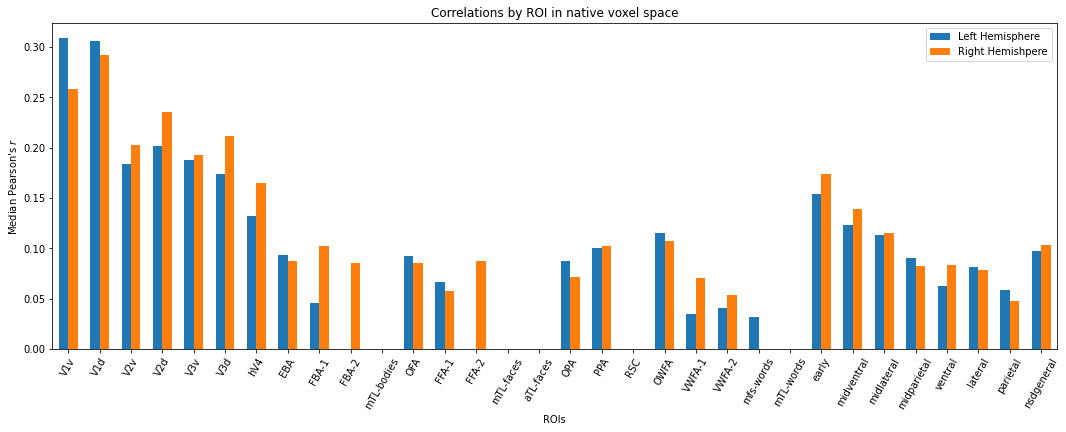

In [57]:
plt.figure(figsize=(18,6))
x = np.arange(len(roi_list))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation_nv, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation_nv, width,label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
# plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_list, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1)
plt.title("Correlations by ROI in native voxel space");

In [58]:
np.any(correlation_roi==1.)

False

# Map from native voxel space to fsaverage surface space
The Algonauts competition requires results in fsaverage space.

## Save voxel predictions as 3d Nifti file

In [59]:
# convert fMRI predictions on validation set
from nilearn.image import load_img, new_img_like

# temp_s3_dir = '/fsx/proj-medarc/fmri/natural-scenes-dataset/temp_s3'
temp_s3_dir = '/scratch/gpfs/KNORMAN/natural-scenes-dataset'

def voxelTo3DNifti(data):
    data = np.copy(data) 
    mask = np.copy(nsd_mask)
    mask = np.tile(mask, (data.shape[0],1,1,1))
    data_to_convert = np.zeros_like(mask, dtype=data.dtype)
    data_to_convert[:,nsd_mask==True]=data
    
    data_to_convert = np.array(data_to_convert).astype(np.float32)
    data_to_convert = np.moveaxis(data_to_convert,0,-1)

    out_niimg_path = 'out.nii.gz'
    avg_out_niimg_path = 'avg_out.nii.gz'

    ref_niimg = load_img(f'{temp_s3_dir}/nsddata_betas/ppdata/subj{subject}/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2_session01.nii.gz')
    assert ref_niimg.get_fdata().shape == data_to_convert.shape[:3]

    out_niimg = new_img_like(ref_niimg, data_to_convert, affine=None, copy_header=True)
    out_niimg.to_filename(out_niimg_path)

    # also output a nifti volume averaging across the first dimension
    avg_out_niimg = new_img_like(ref_niimg, np.mean(data_to_convert,axis=3), affine=None, copy_header=True)
    avg_out_niimg.to_filename(avg_out_niimg_path)
    
    return out_niimg_path, avg_out_niimg

In [60]:
out_niimg_path, avg_out_niimg = voxelTo3DNifti(fmri_val_pred)

### Visualize brain volume (sanity check)

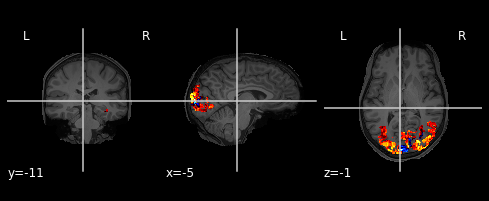

In [61]:
from nilearn import plotting
anat = load_img(f'{temp_s3_dir}/nsddata/ppdata/subj01/anat/T1_0pt8_masked.nii.gz')
plotting.plot_anat(anat).add_overlay(avg_out_niimg,cmap=plotting.cm.cold_hot,clim=[-3,3])
# plotting.view_img(avg_out_niimg,bg_img=anat)

## Convert Nifti from native voxel space -> native surface space -> fsaverage surface space

In [62]:
from nsdcode.nsd_mapdata import NSDmapdata
from nsdcode.nsd_datalocation import nsd_datalocation

def nvTofs(niimg_path):
    nsd = NSDmapdata(temp_s3_dir)

    # Example terminal commands to cp NSD buckets temporarily to local storage 
    # remove "--recursive" if copying a single file instead of contents of a folder
    # in_dir = 'nsddata/ppdata/subj01/transforms/lh.MNI-to-layerB3.mgz'
    # print(f"aws s3 cp --recursive s3://natural-scenes-dataset/{in_dir} {temp_s3_dir}/{in_dir}")

    # Mapping to subject-specific surface space across the three cortical depths
    for hemisphere in ['lh','rh']:
        data = []
        for p in range(3):
            data.append(
                nsd.fit(
                    int(subject),
                    'func1pt8', # source space
                    f'{hemisphere}.layerB{p+1}', # target space
                    niimg_path,
                    'cubic',
                    badval=0
                )
            )
        data = np.array(data)
        assert np.all(data==0) == False

        # Now we average results across the three cortical depths and use
        # nearest-neighbor interpolation to bring the result to fsaverage.
        surface_data = nsd.fit(
            int(subject),
            f'{hemisphere}.white',
            'fsaverage',
            np.mean(data, axis=0),
            interptype=None,
            badval=0,
            fsdir=f'{temp_s3_dir}/nsddata/freesurfer/subj01')
        if hemisphere=='lh':
            lh_fmri = surface_data
        elif hemisphere=='rh':
            rh_fmri = surface_data
        print(f"hemisphere {hemisphere}: surface_data.shape=", surface_data.shape)



    lh_fmri = lh_fmri.astype(np.float32)
    rh_fmri = rh_fmri.astype(np.float32)

    assert not np.all(lh_fmri == rh_fmri)
    
    return lh_fmri, rh_fmri

In [63]:
lh_fmri_val_pred, rh_fmri_val_pred = nvTofs(out_niimg_path)

volumes: 100%|███████████████████████████████| 300/300 [00:48<00:00,  6.15it/s]


data array passed
hemisphere lh: surface_data.shape= (163842, 300)


volumes: 100%|███████████████████████████████| 300/300 [00:48<00:00,  6.23it/s]


data array passed
hemisphere rh: surface_data.shape= (163842, 300)


In [64]:
print(lh_fmri_val_pred.shape, rh_fmri_val_pred.shape)

(163842, 300) (163842, 300)


In [65]:
# convert original validation datasplit to fsaverage? where is the webdataset split in fsaverage space?
out_niimg_path, avg_out_niimg = voxelTo3DNifti(fmri_val)
lh_fmri_val, rh_fmri_val = nvTofs(out_niimg_path)

volumes: 100%|███████████████████████████████| 300/300 [00:47<00:00,  6.28it/s]


data array passed
hemisphere lh: surface_data.shape= (163842, 300)


volumes: 100%|███████████████████████████████| 300/300 [00:48<00:00,  6.24it/s]


data array passed
hemisphere rh: surface_data.shape= (163842, 300)


In [66]:
indices = range(100,103)
print(lh_fmri_val.shape, lh_fmri_val[0,indices])
print(rh_fmri_val.shape, rh_fmri_val[0,indices])
print(lh_fmri_val_pred.shape, lh_fmri_val_pred[0,indices])
print(rh_fmri_val_pred.shape, rh_fmri_val_pred[0,indices])
print(np.sum(lh_fmri_val-lh_fmri_val_pred))
print(np.sum(rh_fmri_val-rh_fmri_val_pred))

print(fmri_val.shape, fmri_val[0, indices])
print(fmri_val_pred.shape, fmri_val_pred[0, indices])
print(np.sum(fmri_val.numpy()-fmri_val_pred))

print(np.any(np.isnan(lh_fmri_val)))
print(np.any(np.isnan(lh_fmri_val_pred)))
print(np.any(np.isnan(rh_fmri_val)))
print(np.any(np.isnan(rh_fmri_val_pred)))

(163842, 300) [-2.3147393e-22 -6.7598937e-22  4.6217828e-22]
(163842, 300) [ 8.0116299e-19 -3.3027527e-18  2.9516550e-18]
(163842, 300) [-5.8006514e-23 -5.8006514e-23 -8.8991740e-23]
(163842, 300) [3.3822164e-19 3.3822164e-19 2.5491129e-19]
107471.84
99563.51
torch.Size([300, 15724]) tensor([ 0.3027, -0.3076, -0.5547])
(300, 15724) [-0.09014918 -0.01176878 -0.07303096]
80247.56116937235
False
False
False
False


In [67]:
# convert test predictions
out_niimg_path, avg_out_niimg = voxelTo3DNifti(fmri_test_pred)
lh_fmri_test, rh_fmri_test = nvTofs(out_niimg_path)

volumes: 100%|███████████████████████████████| 159/159 [00:25<00:00,  6.20it/s]


data array passed
hemisphere lh: surface_data.shape= (163842, 159)


volumes: 100%|███████████████████████████████| 159/159 [00:25<00:00,  6.19it/s]


data array passed
hemisphere rh: surface_data.shape= (163842, 159)


## Evaluations in fsaverage space

In [68]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[0])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[0])):
    lh_correlation[v] = corr(lh_fmri_val_pred[v,:], lh_fmri_val[v,:])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[0])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[0])):
    rh_correlation[v] = corr(rh_fmri_val_pred[v,:], rh_fmri_val[v,:])[0]

  1%|▏                                | 1232/163842 [00:00<00:13, 12316.28it/s]/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|███████████████████████████████| 163842/163842 [00:13<00:00, 12408.94it/s]


In [69]:
print(rh_correlation.shape)
print(lh_correlation.shape)
v=1
print(lh_fmri_val_pred[v,:].shape)

corr(lh_fmri_val_pred[v,:], lh_fmri_val[v,:])[0]

(163842,)
(163842,)
(300,)


-0.011925675525254392

In [70]:
print(np.unique(rh_correlation))

[-0.22348141 -0.19902986 -0.18198657 ...  0.62774112  0.63112096
         nan]


In [71]:
print(np.sum(np.isnan(rh_correlation)))
print(np.sum(np.isnan(lh_correlation)))

53
0


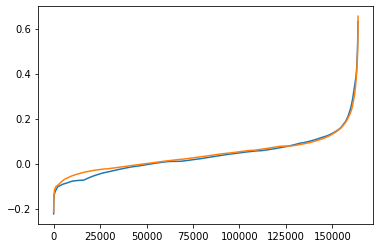

In [72]:
plt.plot(np.sort(rh_correlation))
plt.plot(np.sort(lh_correlation))

In [73]:
# # get correlation by ROI using NSD files
# roi_list = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "nsdgeneral"]

# lh_roi_correlation = []
# rh_roi_correlation = []
# for hemisphere in ['left', 'right']:
#     if hemisphere == 'left':
#         correlation = lh_correlation
#     else:
#         correlation = rh_correlation
#     for roi in tqdm(roi_list):
#         mask_roi = getRoiMask(hemisphere,roi, space = 'surface')
#         test = np.isnan(mask_roi)
#         if True in np.unique(test):
#             print(hemisphere, roi)
#         print("Mask shape:",mask_roi.shape)
#         print("Surface fsaverage shape:",correlation.shape)
#         correlation_roi = correlation[mask_roi==1]
#         test = np.isnan(correlation_roi)
#         if True in np.unique(test):
#             print(hemisphere, roi)

#         if hemisphere == 'left':
#             lh_roi_correlation.append(correlation_roi)
#         else:
#             rh_roi_correlation.append(correlation_roi)
            

In [74]:
# get correlation by ROI using Algonauts files and code

# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_fsaverage_space.npy',
    'lh.floc-bodies_fsaverage_space.npy', 'lh.floc-faces_fsaverage_space.npy',
    'lh.floc-places_fsaverage_space.npy', 'lh.floc-words_fsaverage_space.npy',
    'lh.streams_fsaverage_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_fsaverage_space.npy',
    'rh.floc-bodies_fsaverage_space.npy', 'rh.floc-faces_fsaverage_space.npy',
    'rh.floc-places_fsaverage_space.npy', 'rh.floc-words_fsaverage_space.npy',
    'rh.streams_fsaverage_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
            
roi_names.append('nsdgeneral')
nsdgeneral_lh = np.load(os.path.join(args.data_dir, 'roi_masks',
    'lh.all-vertices_fsaverage_space.npy'))
nsdgeneral_rh = np.load(os.path.join(args.data_dir, 'roi_masks',
    'rh.all-vertices_fsaverage_space.npy'))
nsdgeneral_lh = lh_correlation[nsdgeneral_lh==1]
nsdgeneral_rh = rh_correlation[nsdgeneral_rh==1]
lh_roi_correlation.append(nsdgeneral_lh)
rh_roi_correlation.append(nsdgeneral_rh)

In [75]:
print(len(lh_roi_correlation))
print(len(rh_roi_correlation))
print(rh_roi_correlation[31].shape)
print(rh_roi_correlation[0].shape)
for i, roi in enumerate(roi_list):
    if np.any(np.isnan(lh_roi_correlation[i])):
        print('left')
        print(roi)
        print()
    if np.any(~np.isnan(rh_roi_correlation[i])):
        print('right')
        print(roi)
        print()
test = np.array(rh_roi_correlation[31])
print(~np.isnan(rh_roi_correlation[31]))
correlationmod = test[~np.isnan(test)==True]
print(np.median(correlationmod))

32
32
(20544,)
(444,)
right
V1v

right
V1d

right
V2v

right
V2d

right
V3v

right
V3d

right
hV4

right
EBA

right
FBA-1

right
FBA-2

right
OFA

right
FFA-1

right
FFA-2

right
OPA

right
PPA

right
RSC

right
OWFA

right
VWFA-1

right
VWFA-2

right
early

right
midventral

right
midlateral

right
midparietal

right
ventral

right
lateral

right
parietal

right
nsdgeneral

[ True  True  True ...  True  True  True]
0.12215525193321407


In [76]:
# # Create the plot
# lh_median_roi_correlation = [np.median(lh_roi_correlation[r]) for r in range(len(lh_roi_correlation))]
# rh_median_roi_correlation = [np.median(rh_roi_correlation[r]) for r in range(len(rh_roi_correlation))]
# plt.figure(figsize=(18,6))
# x = np.arange(len(roi_list))
# width = 0.30
# plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
# plt.bar(x + width/2, rh_median_roi_correlation, width,label='Right Hemishpere')
# plt.xlim(left=min(x)-.5, right=max(x)+.5)
# plt.ylim(bottom=0, top=1)
# plt.xlabel('ROIs')
# plt.xticks(ticks=x, labels=roi_list, rotation=60)
# plt.ylabel('Median Pearson\'s $r$')
# plt.legend(frameon=True, loc=1);
# plt.title("Correlations by ROI in fsaverage surface space.")

In [77]:
print(lh_correlation)
print(lh_correlation.shape)
print(lh_roi_correlation[30].shape)

[ 0.07774911 -0.01192568  0.01014855 ... -0.01375464 -0.00870127
  0.04505775]
(163842,)
(2346,)


/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


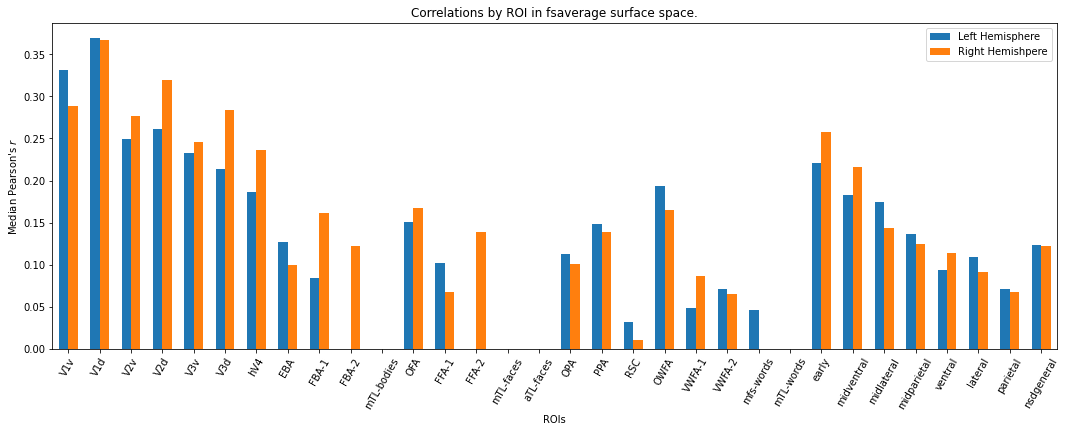

In [78]:
# Create the plot
lh_median_roi_correlation_fs = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation_fs = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation_fs, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation_fs, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
# plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1)
plt.title("Correlations by ROI in fsaverage surface space.");

### Effect on ROI corelations when converting from native voxel to surface fsaverage space

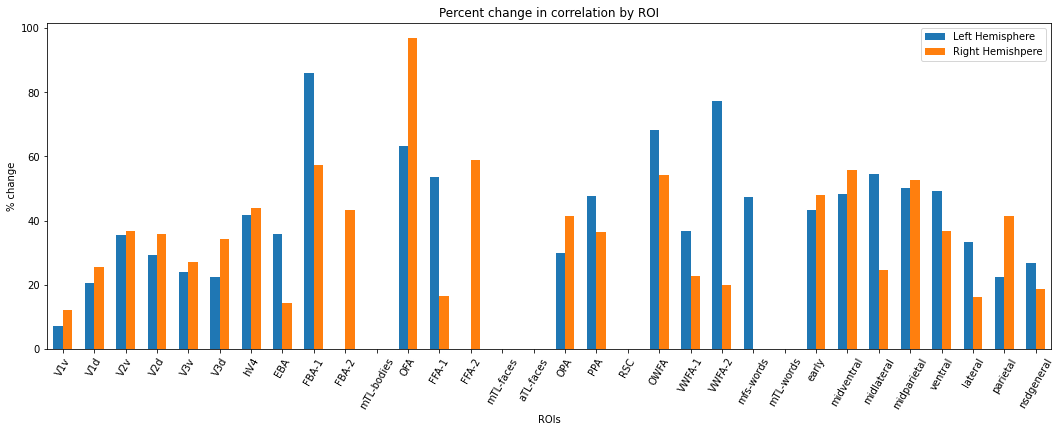

In [79]:
lh_correlation_change = np.array(lh_median_roi_correlation_fs)/np.array(lh_median_roi_correlation_nv)*100-100
rh_correlation_change = np.array(rh_median_roi_correlation_fs)/np.array(rh_median_roi_correlation_nv)*100-100
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_correlation_change, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_correlation_change, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
# plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('% change')
plt.legend(frameon=True, loc=1)
plt.title("Percent change in correlation by ROI");

## Visualize surface activations

(163842, 300)
(163842, 300)


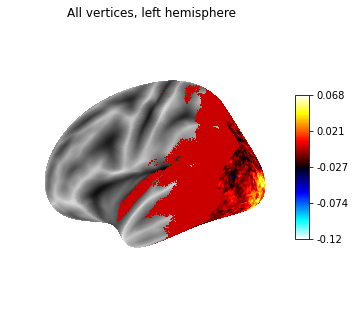

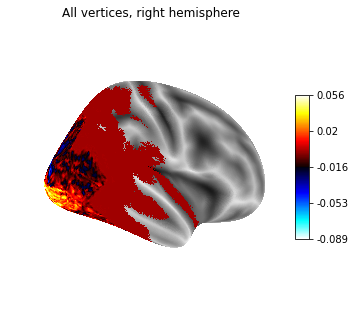

In [80]:
# Create the interactive brain surface map
from nilearn import datasets
for hemisphere in ['left','right']:
    if hemisphere=='left':
        surface_data = lh_fmri_val_pred
    elif hemisphere=='right':
        surface_data = rh_fmri_val_pred
    #fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
    fsaverage = datasets.fetch_surf_fsaverage('fsaverage', data_dir='/scratch/gpfs/dw26')
    print(surface_data.shape)
    plotting.plot_surf(
        surf_mesh=fsaverage['infl_'+hemisphere],
        surf_map=np.mean(surface_data,axis=1),
#         surf_map = surface_data,
        bg_map=fsaverage['sulc_'+hemisphere],
        hemi=hemisphere,
        view='lateral',
        threshold=1e-14,
        cmap='cold_hot',
        colorbar=True,
        title='All vertices, '+hemisphere+' hemisphere'
        )

# Save results in a way compatible with Algonauts submission
After predicted data of all subjects and hemispheres have been saved, zip the parent submission folder (algonauts_2023_challenge_submission), which can then be submitted to CodaLab.

In [81]:
np.save(f'algonauts_2023_challenge_submission/subj{subject}/lh_pred_test.npy',lh_fmri_test)
np.save(f'algonauts_2023_challenge_submission/subj{subject}/rh_pred_test.npy',rh_fmri_test)
print("Saved predictions!")

Saved predictions!
